## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models.deeplab import DeepLab

from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplab")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [25]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

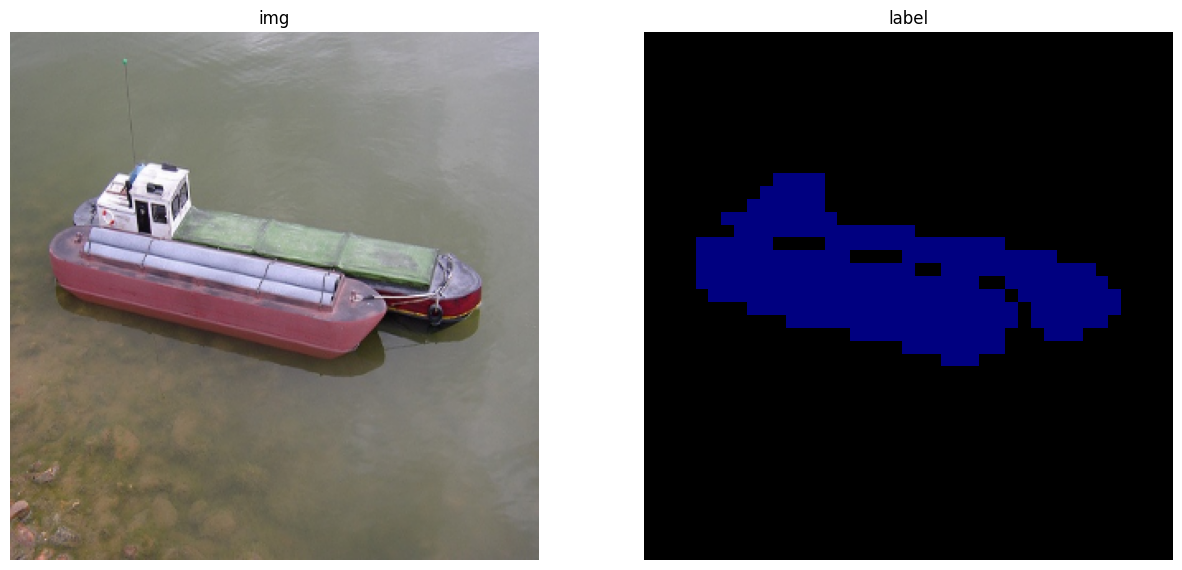

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [11]:
model = DeepLab(NUM_CLASS + 1, frozen_backbone=True).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DeepLab                                       --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

In [13]:
EPOCHES = 30

In [14]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion)

100%|██████████| 91/91 [02:46<00:00,  1.83s/it]


epoch 1 : 0.034852234789958365


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 2 : 0.018834111761752065


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 3 : 0.014893266658943433


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 4 : 0.01298556741900169


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 5 : 0.011944937284339915


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 6 : 0.01110468421049498


100%|██████████| 91/91 [00:42<00:00,  2.15it/s]


epoch 7 : 0.010307133279658936


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 8 : 0.009779956099669357


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 9 : 0.009250623875062217


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 10 : 0.008697761053853965


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 11 : 0.008186604663893416


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 12 : 0.007876292423723818


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 13 : 0.007490553739634189


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 14 : 0.007178528515806237


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 15 : 0.006823539068656308


100%|██████████| 91/91 [00:45<00:00,  1.98it/s]


epoch 16 : 0.006535036868037103


100%|██████████| 91/91 [00:45<00:00,  1.99it/s]


epoch 17 : 0.006227945289728078


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 18 : 0.005943796704881466


100%|██████████| 91/91 [00:44<00:00,  2.06it/s]


epoch 19 : 0.005702438759156964


100%|██████████| 91/91 [00:43<00:00,  2.07it/s]


epoch 20 : 0.005485438401452624


100%|██████████| 91/91 [00:44<00:00,  2.06it/s]


epoch 21 : 0.0052755247637793256


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 22 : 0.005071504238563089


100%|██████████| 91/91 [00:43<00:00,  2.08it/s]


epoch 23 : 0.004871684016537044


100%|██████████| 91/91 [00:43<00:00,  2.09it/s]


epoch 24 : 0.004668034144912611


100%|██████████| 91/91 [00:43<00:00,  2.09it/s]


epoch 25 : 0.00453156311893938


100%|██████████| 91/91 [00:45<00:00,  2.02it/s]


epoch 26 : 0.004373066805323566


100%|██████████| 91/91 [00:44<00:00,  2.03it/s]


epoch 27 : 0.004235309146979189


100%|██████████| 91/91 [00:43<00:00,  2.07it/s]


epoch 28 : 0.004110810178035235


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 29 : 0.003974444342899945


100%|██████████| 91/91 [00:45<00:00,  2.00it/s]

epoch 30 : 0.0038729227265691035


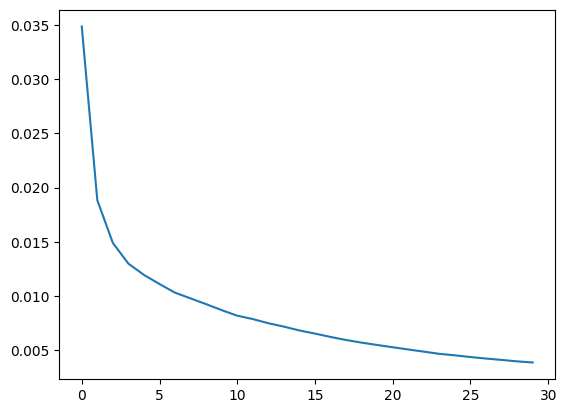

In [17]:
plt.plot(training_loss)

In [20]:
model_path = artifacts_path.joinpath('deeplab.pth')

In [21]:
torch.save(model.state_dict(), model_path)

In [22]:
get_file_size(model_path)

'82.85MiB'

In [14]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [26]:
from torchmetrics.classification import jaccard

In [64]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1)

model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(NUM_CLASS + 1)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()
        labels = labels.long()

        for class_idx in range(21):
            pred_this_class, gt_this_class = output.eq(class_idx), labels.eq(class_idx)
            coef = 2 * (pred_this_class * gt_this_class).sum() / (1 + pred_this_class.sum() + gt_this_class.sum())
            dice[class_idx].append(coef) 
        metric.update(output, labels)

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


In [28]:
metric.compute()

tensor(0.5326)

In [19]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.6761428
bicycle 0.2979508
bird 0.68931025
boat 0.5135674
bottle 0.4223736
bus 0.58532906
car 0.6466701
cat 0.73570096
chair 0.27432197
cow 0.56075114
diningtable 0.4916821
dog 0.65647525
horse 0.58135617
motorbike 0.5337284
person 0.8018467
pottedplant 0.22623399
sheep 0.526761
sofa 0.2918721
train 0.63598764
tvmonitor 0.4986871
mean dice: 0.5323374


### for image in dataset

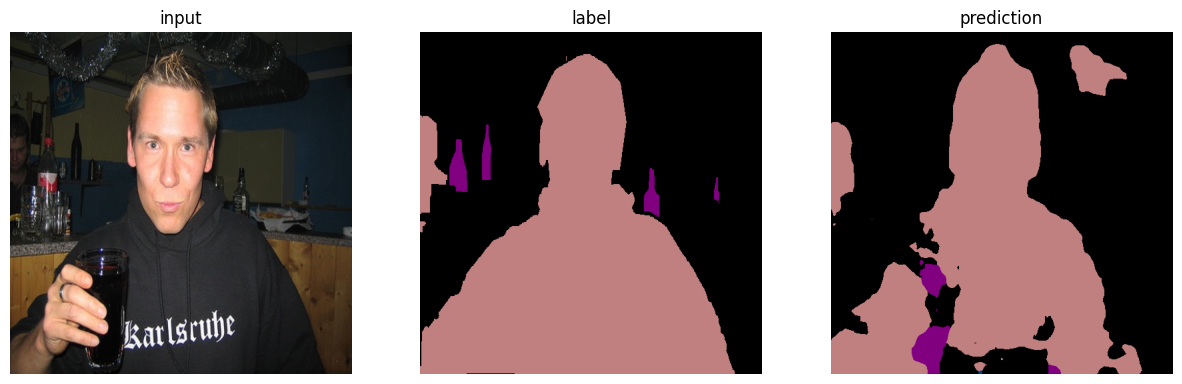

In [23]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

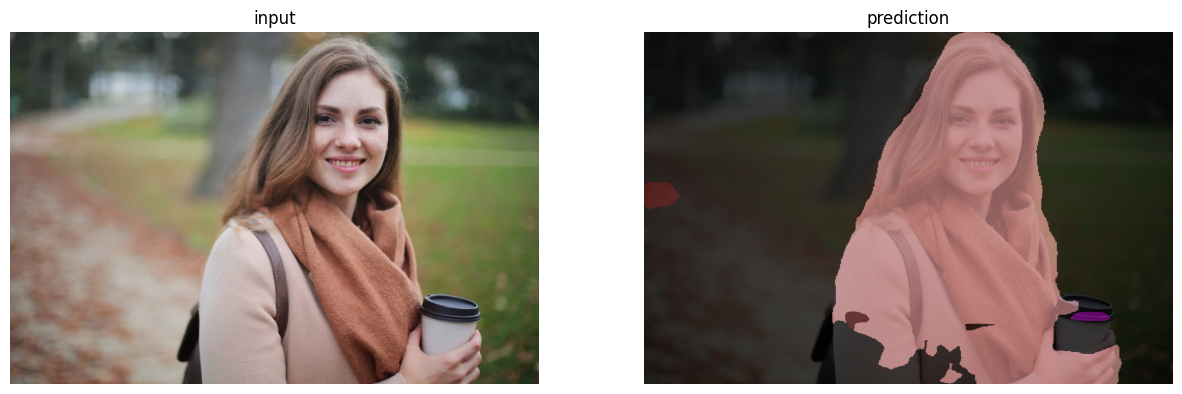

In [24]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )